# Building a RNN model from scratch
In this task, I'm going to build a recurrent neural network from scratch using only numpy for calculation and matplotlib for plotting. 

In [1]:
# import the packages that I need
import numpy as np
import matplotlib.pyplot as plt

# Two Functions needed for this task
When we do the backpropagation through time (BPTT), which is the most important thing in RNN tasks, we have to calculate the gradient. Because I chose sigmoid function as my activation function, it is much better that we define the sigmoid function itself and its derivative function.

In [2]:
# sigmoid function and its derivative 
def sigmoid(x):
    output = 1/(1+np.exp(-x))
    return output

def sigmoid_derivative(output):
    return output*(1-output)

# Generate a lookup table for number to binary code
Before building the RNN model, let's generate our training data, that is the binary code of every number. Thanks for the built-in function of numpy, the 'np.unpackbits' function can help us deal with this problem : )

In [3]:
# let the randomization different every time
a = np.random.randint(1,100)
np.random.seed(a)

# training dataset generation
int2binary = {}
binary_dim = 8

largest_number = pow(2,binary_dim)
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)
for i in range(largest_number):
    int2binary[i] = binary[i]

In [4]:
int2binary[17]

array([0, 0, 0, 1, 0, 0, 0, 1], dtype=uint8)

# Hyperparameters and Weights initialization
The following instance are the hyperparameters, including epoch, learning rate, input dimension, hidden dimension and output dimension. Because our task is binary addition (say, A + B = C) , and we want the model to see just one single digit from A and B at one time. Thus the input dimension is 2 (one from the A, and the other from B). The hidden dimension is randomly set to be 16. Lastly, the output dimension is 1. 


# The three weights matter in this task !!!
1. The weight from input layer to hidden layer is called W_inputtohidden, which the shape is (2,16)
2. The weight from hidden layer to output layer is called W_hiddenToOutput, which the shape is (16,1)
3. The weight from hidden layer to hidden layer is called W_hiddentohidden, which the shape is (16,16)

In [5]:
# hyperparameters
epoch = 20000
lr = 0.1
input_dim = 2
hidden_dim = 16
output_dim = 1

# initialize neural network weights
W_inputtohidden = 2*np.random.random((input_dim,hidden_dim)) - 1
W_hiddenToOutput = 2*np.random.random((hidden_dim,output_dim)) - 1
W_hiddenTohidden = 2*np.random.random((hidden_dim,hidden_dim)) - 1

# generate 3 lists to store the upcoming gradients
W_inputtohidden_update = np.zeros_like(W_inputtohidden)
W_hiddenToOutput_update = np.zeros_like(W_hiddenToOutput)
W_hiddenTohidden_update = np.zeros_like(W_hiddenTohidden)

# Training

Because the binary dimension is 8, so there are 8 positions in every binary code of numbers. For example the binary code of 2 is [0,0,0,0,0,0,1,0], and binary code of 15 is [0,0,0,0,1,1,1,1], and so on. Let's assume that we want to do the addition of 2 and 15. We hope that the machine is fed with two digits in one time, one is from the binary code of 2, and the other one is from the binary code of 15 (both from right to left) For instance, the first time, the machine is fed with array(0,1), and then (1,1), (0,1), (0,1), (0,0), (0,0), (0,0), and (0,0). We hope that the output is [0,0,0,1,0,0,0,1].

# Back Propagation Through Time (BPTT)
The core of this task is the Back Propagation Through Time (BPTT). The mathematical derivation is written in this article (https://medium.com/@vincent831106/recurrent-neural-network-from-scratch-binary-addition-task-55ea0fa771d1)

In [6]:
allError=[]
Acc = []
# training logic
for j in range(epoch):
    # generate a simple addition problem (a + b = c)
    a_int = np.random.randint(largest_number/2) # int version
    a = int2binary[a_int] # binary version of a
    b_int = np.random.randint(largest_number/2) # int version
    b = int2binary[b_int] # binary verions of b

    # true answer
    c_int = a_int + b_int # int version of c
    c = int2binary[c_int] # binary version of c

    # i generate an array d for the best answer given by the machine (binary version)
    d = np.zeros_like(c)
    overallError = 0
    

    outputlayer_deltas = list()
    hidden_values = list()
    hidden_values.append(np.zeros(hidden_dim))

    # moving along the positions in the binary encoding
    for position in range(binary_dim):
        # generate input and output
        X = np.array([[a[binary_dim - position - 1],b[binary_dim - position - 1]]]) # move from right to left
        y = np.array([[c[binary_dim - position - 1]]]).T # true answer, from right to leftl as well
        
        # forward propagation
        hidden = sigmoid(np.dot(X,W_inputtohidden) + np.dot(hidden_values[-1],W_hiddenTohidden))
        # output layer (new binary representation)
        outputlayer = sigmoid(np.dot(hidden,W_hiddenToOutput))


        # calculate the loss value
        outputlayer_error = y - outputlayer
        outputlayer_deltas.append((outputlayer_error)*sigmoid_derivative(outputlayer)*(-1))
        Error = ((outputlayer_error)**2)/2
        
        

        # decode estimate 
        # print("The OutputLayer (binary version): ",outputlayer[0][0])
        d[binary_dim - position - 1] = np.round(outputlayer[0][0])
        
        # store hidden layer foro BPTT
        hidden_values.append(hidden)

    # generate an array to store the hidden and hidden_delta at t + 1 for BPTT
    future_hidden_delta = np.zeros(hidden_dim)
    future_hidden = np.zeros(hidden_dim)

    for position in range(binary_dim):
        X = np.array([[a[position],b[position]]])
        hidden = hidden_values[-position-1]
        prev_hidden = hidden_values[-position-2]
        
        # error at output layer
        outputlayer_delta = outputlayer_deltas[-position-1]
        
        # error at hidden layer * sigmoid_derivative(future_hidden)
        hidden_delta = (future_hidden_delta.dot(W_hiddenTohidden.T) * sigmoid_derivative(future_hidden) + outputlayer_delta.dot(W_hiddenToOutput.T)) * sigmoid_derivative(hidden)

        # update all weights 
        W_hiddenToOutput_update += np.atleast_2d(hidden).T.dot(outputlayer_delta)
        W_hiddenTohidden_update += np.atleast_2d(prev_hidden).T.dot(hidden_delta) 
        W_inputtohidden_update += X.T.dot(hidden_delta) 
        future_hidden_delta = hidden_delta
        future_hidden = hidden
    
    W_inputtohidden -= W_inputtohidden_update * lr
    W_hiddenToOutput -= W_hiddenToOutput_update * lr
    W_hiddenTohidden -= W_hiddenTohidden_update * lr

    W_inputtohidden_update *= 0
    W_hiddenToOutput_update *= 0
    W_hiddenTohidden_update *= 0


    correct = 0
    wrong = 0
    for i in range(binary_dim):
        if d[i]==c[i]:
            correct += 1
        else:
            wrong += 1
    accuracy = correct / binary_dim *100
    overallError = wrong / binary_dim * 100
    if j%100 == 0:
        Acc.append(accuracy)
        allError.append(overallError)



    # print out result
    if(j %1000 == 0):
        print("epoch",j)
        print("Pred:" , d)
        print("True:" ,c)
        out = 0
        for index,x in enumerate(reversed(d)):
            out += x*pow(2,index)
        print(a_int, " + ",b_int," = ",out)
        print("Error:",overallError)
        print("accuracy =", accuracy,"%")
        print("------------")

epoch 0
Pred: [0 0 0 0 0 0 0 0]
True: [0 1 1 1 1 0 0 0]
65  +  55  =  0
Error: 50.0
accuracy = 50.0 %
------------
epoch 1000
Pred: [1 1 1 0 0 0 1 0]
True: [1 1 1 0 0 1 0 0]
115  +  113  =  226
Error: 25.0
accuracy = 75.0 %
------------
epoch 2000
Pred: [1 1 1 1 1 1 1 1]
True: [0 1 1 0 1 1 1 1]
50  +  61  =  255
Error: 25.0
accuracy = 75.0 %
------------
epoch 3000
Pred: [0 0 0 1 1 1 1 0]
True: [0 0 0 1 1 1 1 1]
25  +  6  =  30
Error: 12.5
accuracy = 87.5 %
------------
epoch 4000
Pred: [0 0 0 1 1 0 1 0]
True: [0 0 1 0 1 0 1 0]
29  +  13  =  26
Error: 25.0
accuracy = 75.0 %
------------
epoch 5000
Pred: [0 1 1 1 1 0 0 0]
True: [0 1 1 1 1 0 0 0]
108  +  12  =  120
Error: 0.0
accuracy = 100.0 %
------------
epoch 6000
Pred: [1 1 0 1 0 0 1 0]
True: [1 1 0 1 0 0 1 0]
125  +  85  =  210
Error: 0.0
accuracy = 100.0 %
------------
epoch 7000
Pred: [0 1 0 0 0 1 1 0]
True: [0 1 0 0 0 1 1 0]
17  +  53  =  70
Error: 0.0
accuracy = 100.0 %
------------
epoch 8000
Pred: [1 0 1 0 1 1 1 1]
True: [1 0

# Plotting

Let's plot our result : Loss and Accuracy during training process

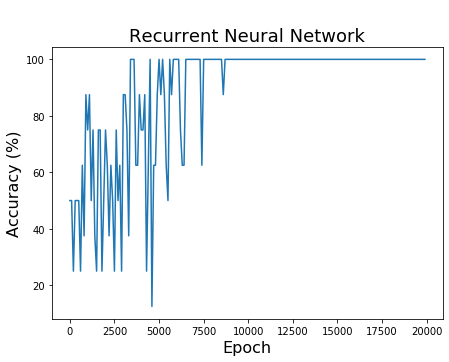

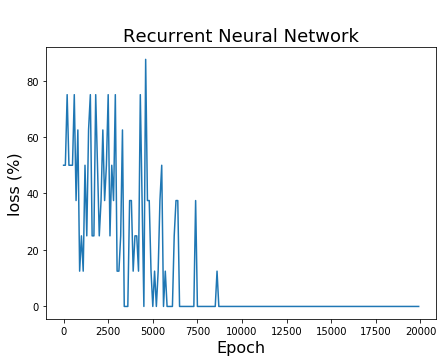

In [7]:
fig = plt.figure(figsize=(7,5))
epoch = np.arange(0,20000,100)
plt.plot(epoch,Acc,linestyle="solid")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Accuracy (%)",fontsize=16)
plt.title("\nRecurrent Neural Network",fontsize=18)
plt.savefig('/Users/vincent/Desktop/RNN_Acc.png')
plt.show()

fig = plt.figure(figsize=(7,5))
epoch = np.arange(0,20000,100)
plt.plot(epoch,allError,linestyle="solid")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("loss (%)",fontsize=16)
plt.title("\nRecurrent Neural Network",fontsize=18)
plt.savefig('/Users/vincent/Desktop/RNN_Loss.png')
plt.show()